# Generate SFS as a function of sigma and population parameters

### Implicit mutation rate simulations and SFS calculations

#### Chris Porras

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rc = {'lines.linewidth': 3, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5',
      'axes.font': 'arial'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette('colorblind')
%matplotlib inline
from scipy.ndimage.filters import laplace

#### Store parameters in a single dict

In [5]:
## Initialize dict of all kwargs
## to be updated by namespace reassignment

kwargs={'mu':10**-6,
      's':10**-2,
      'm':10**-1,
      'pop_size':10**4,
      'dims':(2,2),
      'num_intervals':1000,
      'n': 2,
      'sigma':1}


#### Use a namespace to access parameters in dict

In [6]:
from types import SimpleNamespace
sim = SimpleNamespace(**kwargs)

#### WF + SS simulation

In [7]:
def calculate_f(f,sim):
    ## unpack parameters
    mu = sim.mu
    s = sim.s
    m = sim.m
    pop_size = sim.pop_size
    ## Wright-Fisher diffusion w/Stepping Stone migration
    df = mu*(1-2*f)-s*f*(1-f) \
    +m*laplace(f,mode='wrap')
    ## bounds allele frequencies
    p = np.clip(a= f + df ,a_min=0,a_max=1)
    ## genetic drift sampling
    f= np.random.binomial(pop_size,p)/pop_size
    return f

#### Efficient downsampling for intervals of $\frac{1}{s}$
Can do explicit and implicit mutation by setting $\mu = 0$

In [18]:
def downsample_f(sim):
    dims = sim.dims
    num_intervals = sim.num_intervals
    s = sim.s
    pop_size = sim.pop_size
    mu = sim.mu
    output = np.zeros(tuple([num_intervals])+dims)
    interval = int(1/s)
    num_gens = interval * num_intervals
    f = np.zeros(dims)
    ## Indexing corner of 2D array or last element of 1D 
    f[tuple(np.array(f.shape)-1)] = 1/pop_size
    ## pre-allocate list of when reset happens
    reset_gens = []
    for i in range(num_gens):
        ## update frequencies
        new_f = calculate_f(f,sim)
        ## Check for implicit mu simulation and extinct allele
        if mu==0 and np.all(new_f==0):
            ## if extinct, store previous freqs and reset
            reset_gens.append(i)
            ## Add 1 allele to single element of  
            ## an artbitrarily sized array
            new_f[tuple(np.array(new_f.shape)-1)] = 1/pop_size
        ## Assign next frequencies
        f = new_f
        ## choose freqs every 1/s and before reset happens
        if (i + 1) % interval == 0:
            output[i//interval] = f
    return output

### Gaussian sampling from frequency lattice

In [19]:
from scipy.ndimage import gaussian_filter

In [21]:
def sample_f(f,sigma):
    F = np.zeros(f.shape)
    ## Need to convolve array along spatial axes
    ## so iterate over time axis
    for i in range(f.shape[0]):
        F[i] = gaussian_filter(f[i],sigma=sigma,mode = "wrap")
    return F

### $\langle \zeta \rangle$ calculator

In [23]:
from scipy.special import binom
def freq_sfs(f,n):
    if np.isscalar(f):
        sfs = np.zeros(n+1)
    else:
        sfs = np.zeros(tuple([n+1]) + f.shape)
    for j in range(n+1):
        sfs[j] = binom(n,j)*f**j * (1-f)**(n-j)
    return sfs

### Plot SFS as a function of $s$ and $\sigma$

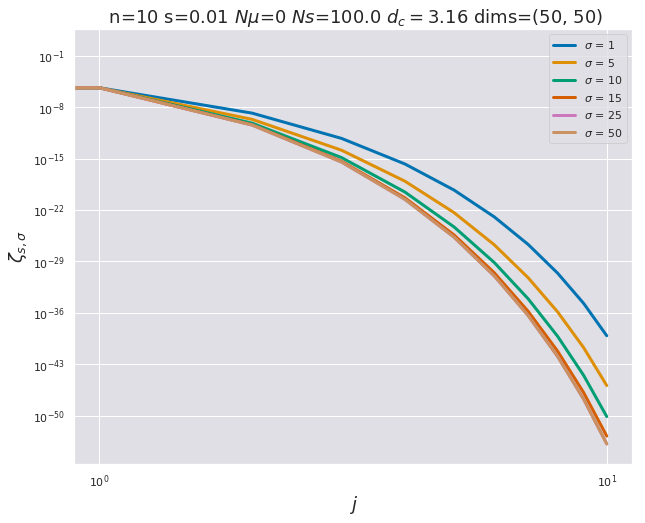

In [24]:
sim.mu = 0
sim.n = 10
sim.dims = (50,50)
sim.num_intervals = 1000

sig_list = [1, 5, 10, 15, 25, 50]

## Simulate frequency landscape for num_intervals
f = downsample_f(sim)

#make plot over j for all sfs(s,sigma)
plt.figure(figsize=(10.0,8.0))
title = (f' n={sim.n} s={sim.s} ' \
        + r'$N\mu$='+f'{sim.pop_size*sim.mu} ' \
        + r'$Ns$='+f'{sim.pop_size*sim.s} ' \
        + r'$d_c=$'+f'{np.round(np.sqrt(sim.m/sim.s),decimals=2)} ' \
        + f'dims={sim.dims}')
plt.title(title)
plt.xlabel(r'$j$')
plt.ylabel(r'$\zeta_{s,\sigma}$')

# j is sample size out of n
j = np.arange(sim.n+1) 

for sig in sig_list:
    sim.sigma = sig
    #sample from f with range of sigma
    F = sample_f(f,sim.sigma)
    #average sampled f over intervals,reps,dims
    sfs = freq_sfs(F,sim.n)
    sfs_avg = np.mean(sfs,axis=(1,2,3))
    label = f'$\sigma$ = {sig}'
    plt.loglog(j,sfs_avg,label=label)

plt.legend()
plt.show()

### Plot a normalized SFS to confirm expected decay as $~\phi[j]$

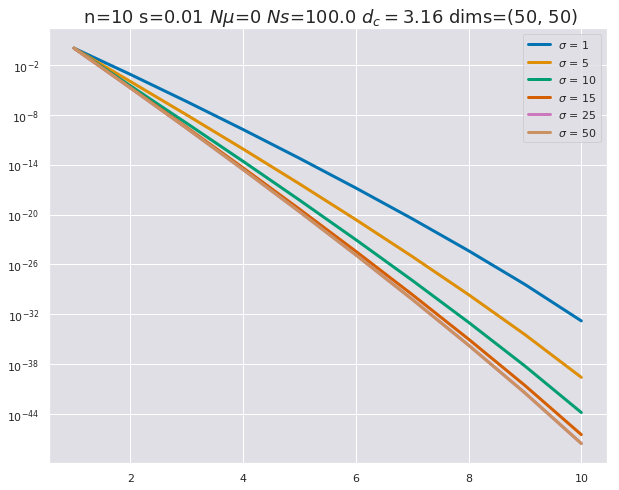

In [27]:
sig_list = [1, 5, 10, 15, 25, 50]

#make plot over j for all sfs(s,sigma)
plt.figure(figsize=(10.0,8.0))
title = (f' n={sim.n} s={sim.s} ' \
        + r'$N\mu$='+f'{sim.pop_size*sim.mu} ' \
        + r'$Ns$='+f'{sim.pop_size*sim.s} ' \
        + r'$d_c=$'+f'{np.round(np.sqrt(sim.m/sim.s),decimals=2)} ' \
        + f'dims={sim.dims}')
plt.title(title)

# j is sample size out of n
j = np.arange(sim.n+1) 

for sig in sig_list:
    sim.sigma = sig
    #sample from f with range of sigma
    F = sample_f(f,sim.sigma)
    #average sampled f over intervals,reps,dims
    sfs = freq_sfs(F,sim.n)
    sfs_avg = np.mean(sfs,axis=(1,2,3))
    norm_sfs = (j*sfs_avg)/sfs_avg[1]
    
    label = f'$\sigma$ = {sig}'
    plt.semilogy(j[1:],norm_sfs[1:],label=label)

plt.legend()
plt.show()

#### Try with a larger $n$

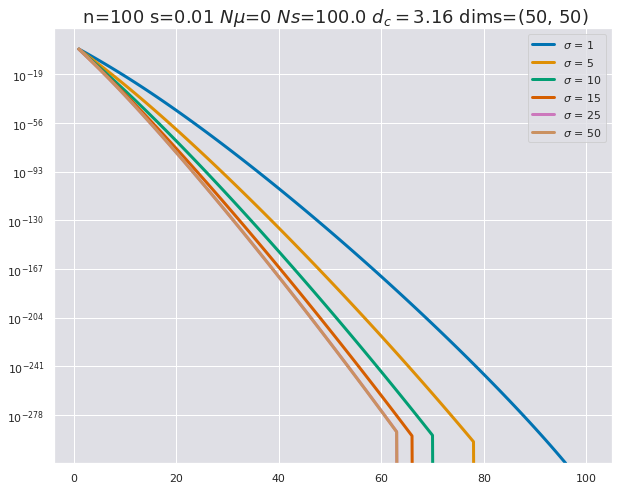

In [28]:
sig_list = [1, 5, 10, 15, 25, 50]
sim.n = 100

#make plot over j for all sfs(s,sigma)
plt.figure(figsize=(10.0,8.0))
title = (f' n={sim.n} s={sim.s} ' \
        + r'$N\mu$='+f'{sim.pop_size*sim.mu} ' \
        + r'$Ns$='+f'{sim.pop_size*sim.s} ' \
        + r'$d_c=$'+f'{np.round(np.sqrt(sim.m/sim.s),decimals=2)} ' \
        + f'dims={sim.dims}')
plt.title(title)

# j is sample size out of n
j = np.arange(sim.n+1) 

for sig in sig_list:
    sim.sigma = sig
    #sample from f with range of sigma
    F = sample_f(f,sim.sigma)
    #average sampled f over intervals,reps,dims
    sfs = freq_sfs(F,sim.n)
    sfs_avg = np.mean(sfs,axis=(1,2,3))
    norm_sfs = (j*sfs_avg)/sfs_avg[1]
    
    label = f'$\sigma$ = {sig}'
    plt.semilogy(j[1:],norm_sfs[1:],label=label)

plt.legend()
plt.show()

### We observe some transition from slightly nonlinear to linear decay as $\sigma > d_c$